# 6. Case Study

The dataset for this homework is posted on Piazza. It documents 482 initial
public offerings (IPOs) of private companies. The goal is to predict which companies attract
venture capital funding.

In [7]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score,roc_curve,auc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

% matplotlib inline

In [8]:
data = pd.read_csv("data.csv")
data.shape
del data['Id']
data.shape


y = data['vc']
del data['vc']
X = data

## (a) Partition and Exploration

** Partition the dataset into a training, developmetn adn a validation subsets of equal size, by randomly selecting rows in the dataset.**

### Partition:

In [9]:
def split_data(X,y):
    
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.3333, random_state=42)
    X_dev, X_val, y_dev, y_val = train_test_split(X_rem, y_rem, train_size = 0.5, random_state=42)
    
    
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_dev.reset_index(drop=True), y_dev.reset_index(drop=True), X_val.reset_index(drop=True), y_val.reset_index(drop=True)

In [10]:
X_train, y_train, X_dev, y_dev, X_val, y_val = split_data(X,y)

print(X_train.shape)
print(X_dev.shape)
print(X_val.shape)

(160, 3)
(161, 3)
(161, 3)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Exploration & Feature Transformations:
**Explore the training set: report one-variable summary statistics, two-variable summary statistics, and discuss your findings.**

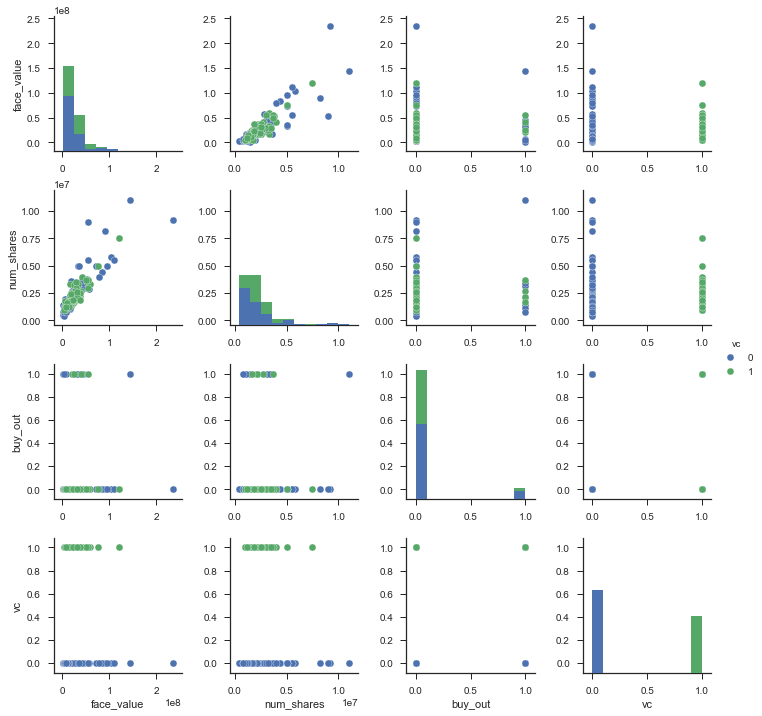

In [11]:
Train = pd.concat([X_train,y_train],axis=1)
ploot = sns.pairplot(Train, hue="vc")

Interestingly, from the plot Face Value vs. num_shares, vc = 1 when the face_value and number of shares is lower. It makes sense as VCs like to fund small startups/companies rather than the big ones.

This dataset is tricky, as no variable is linearly separating VC. so, if we just train classifier with these variables, it will not perform well. Let's include squares of continuous features and see how they distinguishes two classes. 

Both continuous variables have very large values, we can scale them by StandardScaler (min-max normalization):

$$ X_{scaled} = \frac{X - X_{min}}{X_{max}-X_{min}}$$

Also, let's create dummies for buy_out column.

In [12]:
def standard_scaler(X,min_,max_):
    return (X - min_)/(max_ - min_)

# Including squares
def squares(X_train,X_dev,X_val,cols=None):
    for col in cols:
        X_train[col+"_2"] = np.square(X_train[col])
        X_dev[col+"_2"] = np.square(X_dev[col])
        X_val[col+"_2"] = np.square(X_val[col])
    
    return X_train, X_dev, X_val

X_train,X_dev,X_val = squares(X_train, X_dev, X_val, cols = ['face_value','num_shares'])

X_train['value_per_share'] = X_train['face_value']/X_train['num_shares']
X_dev['value_per_share'] = X_dev['face_value']/X_dev['num_shares']
X_val['value_per_share'] = X_val['face_value']/X_val['num_shares']

# scaling face-value
fv_min = X_train['face_value'].min()
fv_max = X_train['face_value'].max()

X_train['face_value'] = standard_scaler(X_train['face_value'],fv_min,fv_max)
X_dev['face_value'] = standard_scaler(X_dev['face_value'],fv_min,fv_max)
X_val['face_value'] = standard_scaler(X_val['face_value'],fv_min,fv_max)

# scaling num_shares
sh_min = X_train['num_shares'].min()
sh_max = X_train['num_shares'].max()

X_train['num_shares'] = standard_scaler(X_train['num_shares'],fv_min,fv_max)
X_dev['num_shares'] = standard_scaler(X_dev['num_shares'],fv_min,fv_max)
X_val['num_shares'] = standard_scaler(X_val['num_shares'],fv_min,fv_max)

# scaling face_value_2
fv_min = X_train['face_value_2'].min()
fv_max = X_train['face_value_2'].max()

X_train['face_value_2'] = standard_scaler(X_train['face_value_2'],fv_min,fv_max)
X_dev['face_value_2'] = standard_scaler(X_dev['face_value_2'],fv_min,fv_max)
X_val['face_value_2'] = standard_scaler(X_val['face_value_2'],fv_min,fv_max)

# scaling num_shares_2

sh_min = X_train['num_shares_2'].min()
sh_max = X_train['num_shares_2'].max()

X_train['num_shares_2'] = standard_scaler(X_train['num_shares_2'],fv_min,fv_max)
X_dev['num_shares_2'] = standard_scaler(X_dev['num_shares_2'],fv_min,fv_max)
X_val['num_shares_2'] = standard_scaler(X_val['num_shares_2'],fv_min,fv_max)


# buy_out dummies
X_train = pd.get_dummies(X_train,columns=['buy_out'])
X_dev = pd.get_dummies(X_dev,columns=['buy_out'])
X_val = pd.get_dummies(X_val,columns=['buy_out'])


Let's add few interaction variables and see if we're getting any edge.

Consider following interction:

$$value\_per\_share = \frac{face\_value}{num\_shares}$$

Let's also consider log transformation to reduce skewness as well as the effect of outliers.

In [13]:
def convert_log(X_train,X_dev,X_val,cols=None):
    for col in cols:
        X_train[col] = np.log1p(X_train[col])
        X_dev[col] = np.log1p(X_dev[col])
        X_val[col] = np.log1p(X_val[col])
    
    return X_train,X_dev,X_val

X_train,X_dev,X_val = convert_log(X_train,X_dev, X_val, cols = ['value_per_share','face_value','num_shares'])

**Key Points**

* There are no features completely discriminating the two classes. 
* The continuous variables contain very large values and are skewed.
* Very small number of training samples are available for analysis.

## (b) Logistic Regression

**Fit logistic regression on the training set. Consider transformations of variables, and the inclusion of higher-order terms if needed. Select the model with the best area under the ROC curve on the development set.**

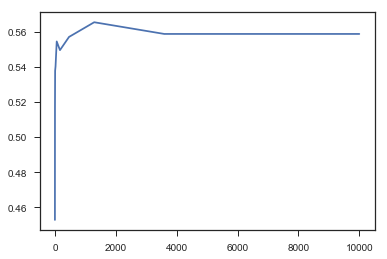

In [14]:
scores = {}
for c in np.logspace(0, 4, 10):
    clf = LogisticRegression(random_state=0, solver='lbfgs',C = c,
                         multi_class='ovr').fit(X_train,y_train)
    scores[c] = roc_auc_score(y_dev,clf.predict(X_dev))

lists = sorted(scores.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [213]:
print("Best AUC score on development set: ", scores[max(scores, key=scores.get)])
print("C: ", max(scores, key=scores.get))

lr = LogisticRegression(random_state=0, solver='lbfgs',C = max(scores, key=scores.get),
                         multi_class='ovr').fit(X_train,y_train)

Best AUC score on development set:  0.565426356589
C:  1291.54966501


## (c) Linear Discriminant Analysis

**Fit linear discriminant analysis on the training set. Consider transformations of variables, and the inclusion of higher-order terms if needed. Select the model with the best area under the ROC curve on the development set.** 

For LDA, we can only train the model based on continuous features as we assume that they're normally distributed.

In [214]:
X_train_cont = X_train.copy()
X_dev_cont = X_dev.copy()
X_val_cont = X_val.copy()

X_train_cont.drop(['buy_out_0', 'buy_out_1'], axis=1,inplace=True)
X_dev_cont.drop(['buy_out_0', 'buy_out_1'], axis=1,inplace=True)
X_val_cont.drop(['buy_out_0', 'buy_out_1'], axis=1,inplace=True)

In [215]:
clf = LinearDiscriminantAnalysis()

clf.fit(X_train_cont,y_train)

roc_auc_score(y_dev,clf.predict(X_dev_cont))

0.58798449612403103

We performed hyperparameter optimization for regularization in logistic regression. Without any hyperparameter optimization, LDA performed much better than Logistic Regression. Note that, it didn't even use the buy_out categorical feature.

## (d) ROC curves

**Evaluate the performance of the classifiers using ROC curves on the training and on the validation set.**

In [216]:
def plot_roc(y_true,y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_true,y_pred)

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression Train:

In [6]:
plot_roc(y_train,lr.predict(X_train),"Logistic Regression Train")
plot_roc(y_val,lr.predict(X_val),"Logistic Regression Val")

NameError: name 'plot_roc' is not defined

### Logistic Regression Val:

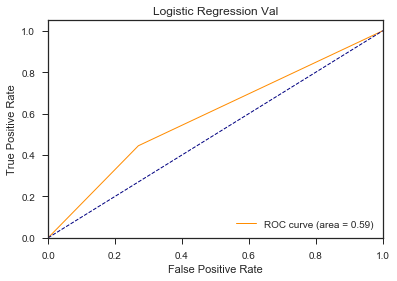

### LDA Train:

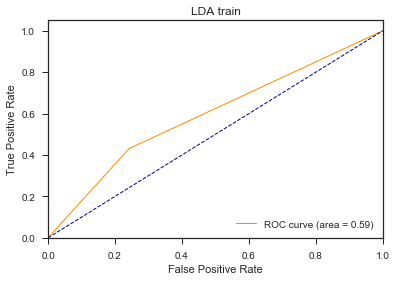

In [219]:
plot_roc(y_train,clf.predict(X_train_cont),"LDA train")

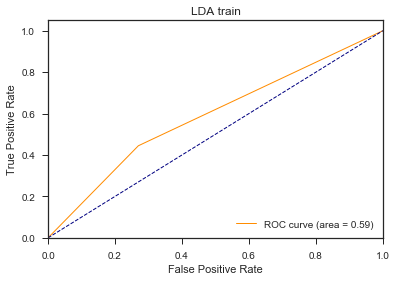

In [220]:
plot_roc(y_val,clf.predict(X_val_cont),"LDA train")

## (e) Summary

**Summarize your findings. How do the results differ between the training and the validation set? Which approach(es) perform(s) better on the validation set? What is are the reasons for this difference in performance? Which models are more interpretable?**